In [1]:
#!pip install torch torchvision torchaudio

In [2]:
import pandas as pd
import optuna
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.preprocessing import MaxAbsScaler
import torch
import numpy as np

torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True



from utils import *


optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
# Suppress pandas warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [3]:
versions = [
            'classic',
            'stations_basic', 
            'stations_weighted_all',
            'stations_weights_inverse',
            'stations_weights_gaussian',
            'stations_weights_logarithmic',
            'stations_weights_linear'
                ]

n_trials= 25
random_state = 42
test_size = 0.2
val_size = 0.1
epochs = 4000
lr = 0.001

model_classes = [
    FlexibleMLP,
]

In [4]:
df_scores = pd.DataFrame(columns=['version', 'model', 'r2', 'mse', 'mae', 'best_params', 'validation_mae'])
studies = {}

classic - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

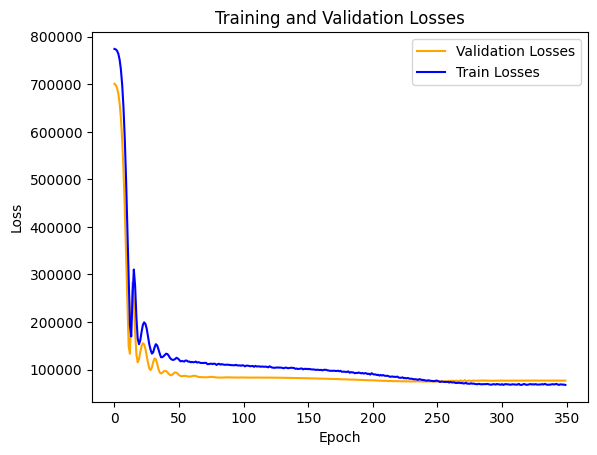

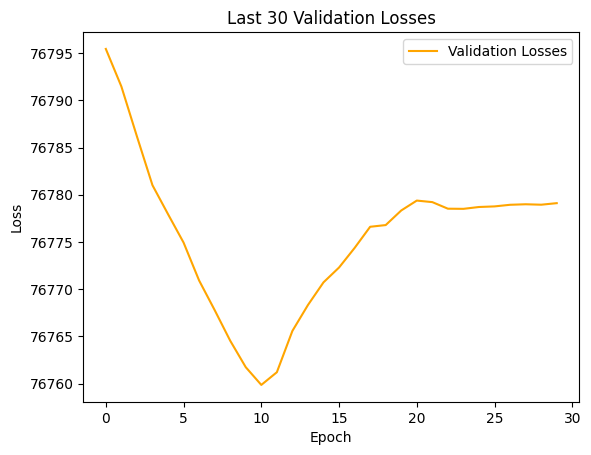

stations_basic - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

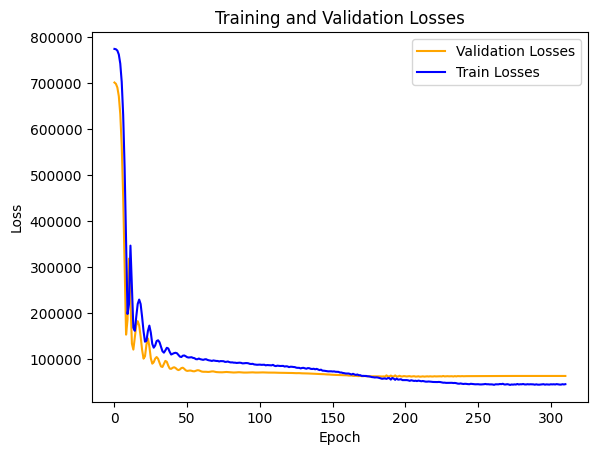

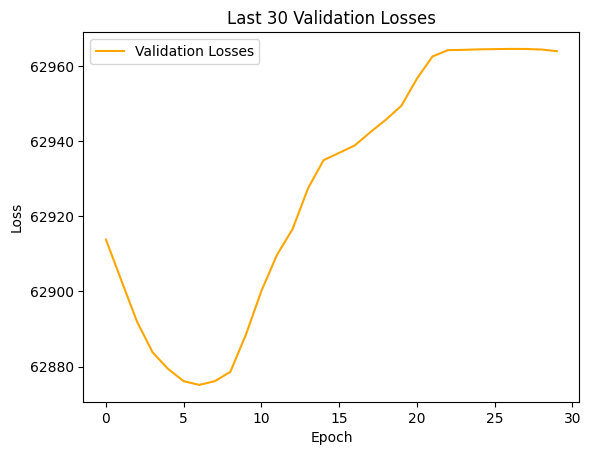

stations_weighted_all - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

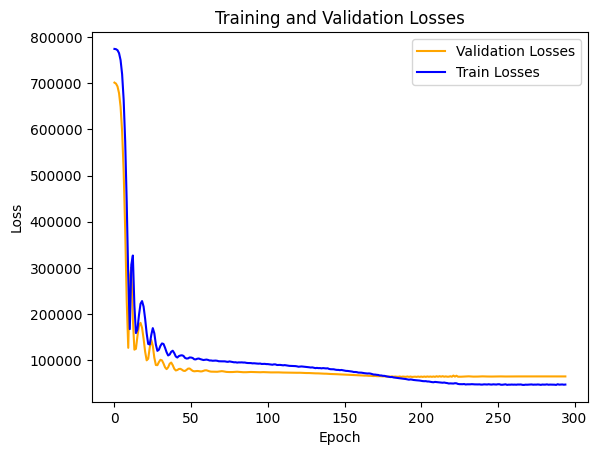

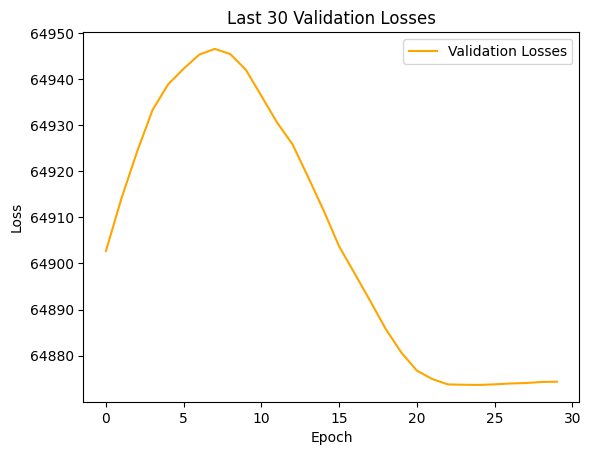

stations_weights_inverse - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

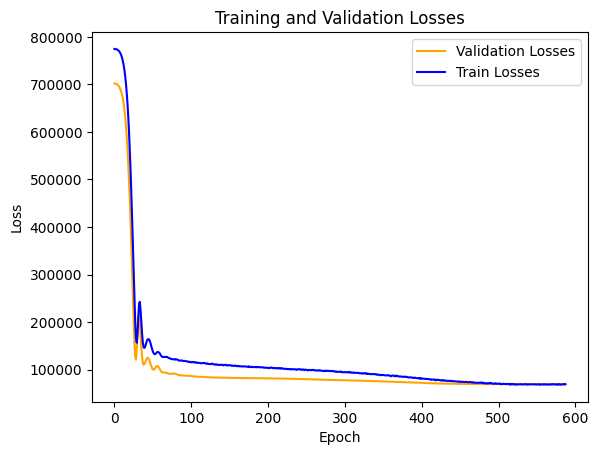

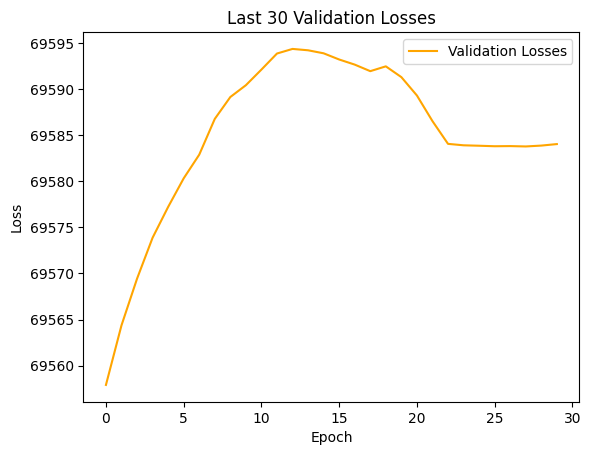

stations_weights_gaussian - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

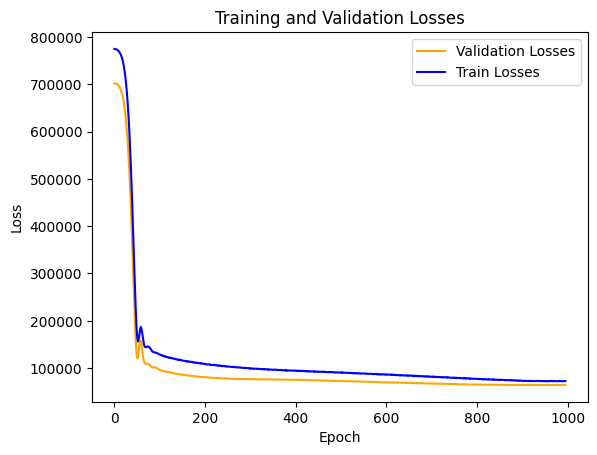

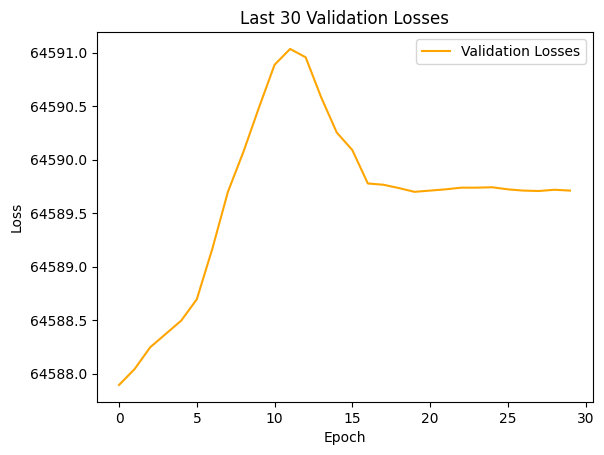

stations_weights_logarithmic - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

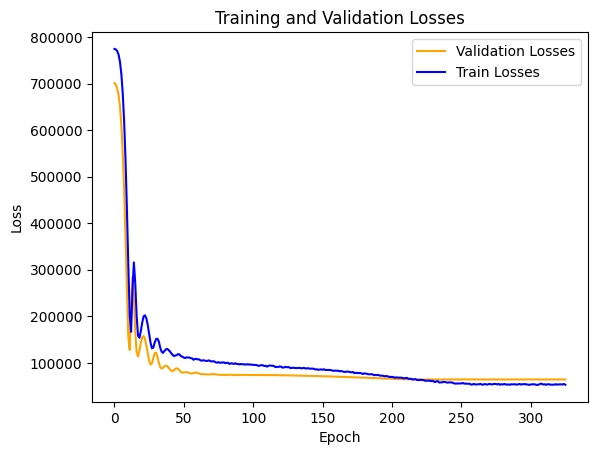

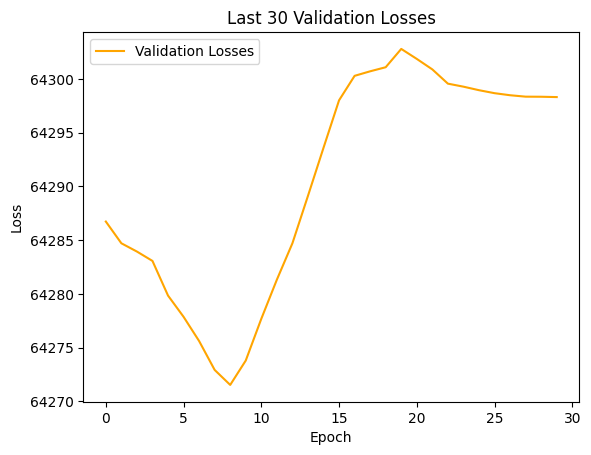

stations_weights_linear - FlexibleMLP


  0%|          | 0/25 [00:00<?, ?it/s]

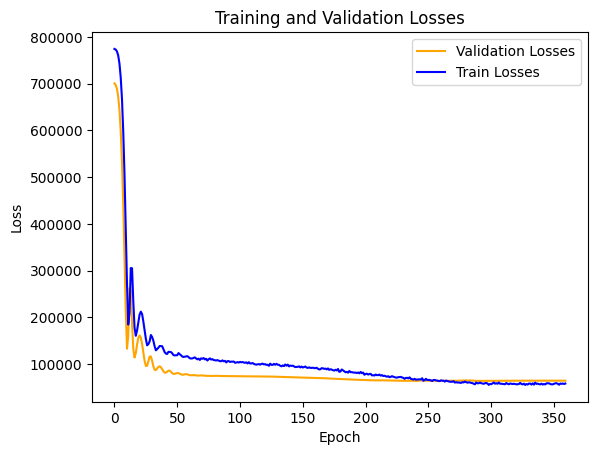

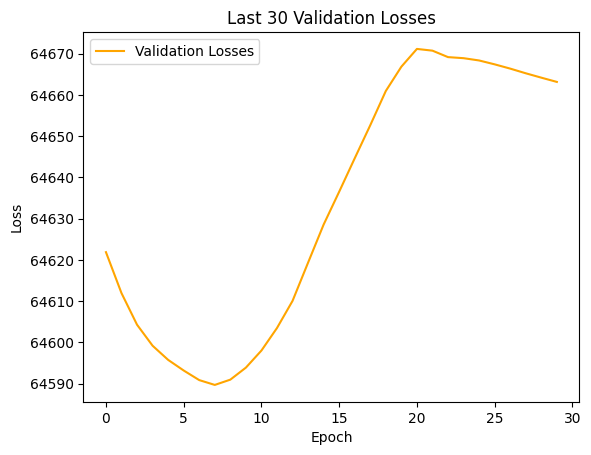

In [5]:
for version in versions:
    for model_class in model_classes:
        print("="*50)
        print(f'{version} - {model_class.__name__}')
        X_train_val, X_test, y_train_val, y_test  = prepare_data(version=version, test_size=test_size, random_state=random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=random_state)
        # Define the metric function for optimization
        metric_function = mean_absolute_error
        
        
        # Create the objective function with additional parameters
        objective = create_objective_mlp(X_train, X_val, y_train, y_val, epochs=epochs, lr = lr)
        study = optuna.create_study(direction="minimize", study_name=f"{version}_{model_class.__name__}")
        
           
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True,gc_after_trial=True)

        best_params = study.best_params
        best_params["layer_sizes"] = deserialize_tuple(best_params["layer_sizes"])

        model = model_class(**best_params, input_size= X_train.shape[1], output_size = 1)
        model = model.cuda()

            
        
        # Fit the scaler on the training set and transform the training and testing sets
        scaler = MaxAbsScaler()
        X_train_val_scaled = scaler.fit_transform(X_train_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)


               
        # Convert data to PyTorch tensors
        X_train_val_tensor = torch.tensor(X_train_val_scaled, dtype=torch.float32).to('cuda')
        y_train_val_tensor = torch.tensor(y_train_val.values, dtype=torch.float32).view(-1, 1).to('cuda')
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to('cuda')
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to('cuda')
        
        train(model, X_train_val_tensor, y_train_val_tensor, X_test_tensor, y_test_tensor, criterion, optimizer, epochs=epochs, verbose = True)
        
        y_pred = predict(model, X_test_tensor)
        y_pred = y_pred.flatten()
        
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        validation_mae = study.best_value
        new_row = {'version': version, 'model': model_class.__name__, 'r2': r2, 'mse': mse, 'mae': mae, 'best_params': study.best_params, 'validation_mae': validation_mae}
        df_scores = pd.concat([df_scores, pd.DataFrame([new_row])], ignore_index=True)
        # save the study
        studies[f'{version}_{model_class.__name__}'] = study

        

In [10]:
df_scores.sort_values(by='mae', ascending=True, inplace=False).head()


version        model        r2           mse  \
1                stations_basic  FlexibleMLP  0.563330  62963.987172   
2         stations_weighted_all  FlexibleMLP  0.550081  64874.372490   
6       stations_weights_linear  FlexibleMLP  0.551546  64663.171237   
5  stations_weights_logarithmic  FlexibleMLP  0.554076  64298.317976   
4     stations_weights_gaussian  FlexibleMLP  0.552055  64589.713545   

          mae                                        best_params  \
1  162.344252  {'layer_sizes': '2048,1024,1024,512,256', 'dro...   
2  167.332246  {'layer_sizes': '2048,1024,1024,512,256', 'dro...   
6  169.781895  {'layer_sizes': '2048,1024,1024,256', 'dropout...   
5  170.557208  {'layer_sizes': '2048,1024,1024,256', 'dropout...   
4  173.253527  {'layer_sizes': '512,256,64', 'dropout_rate': ...   

   validation_mae  
1      162.416183  
2      166.106445  
6      166.424179  
5      163.538666  
4      178.220291

In [11]:
# save studies object
add_name = '_'.join(versions)
import pickle
with open(f'studies/studies_MLP.pkl', 'wb') as f:
    pickle.dump(studies, f)
# save results
df_scores.to_csv(f'results/results_MLP.csv', index=False)

In [12]:
# load studies object

#studies = pickle.load(open(f'studies_{add_name}.pkl', 'rb'))

In [13]:
best_params["layer_sizes"]

(2048, 1024, 1024, 256)